In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
data = ['mnist', 'goodreads']

### Prior plotting

In [3]:
filename = 'prior_data_mnist_skips_False_prior_NAF_numnafs_5_samples_1_zdim_64.txt'
file = open('./plot_data/mnist/{}'.format(filename))

In [4]:
data = np.array([float(val) for val in ' '.join([value for value in file.read().split('\n')][:-1]).split(' ')]).reshape(-1, 64)

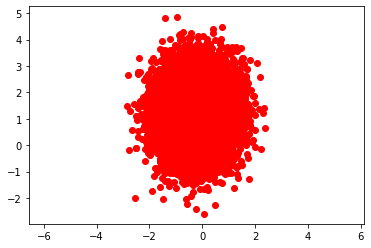

In [5]:
plt.scatter(data[:, 0], data[:, 1], c='r')
plt.axis('equal');